In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
import re

In [16]:
!pip install matplotlib
!pip install wordcloud
!pip install nltk
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.2 MB/s eta 0:00:00
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 14.0 MB/s eta 0:00:00
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.9 MB/s eta 0:00:00a 0:00:01


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

In [12]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Classification of subreddit") \
    .getOrCreate()

24/04/29 19:12:19 WARN Utils: Your hostname, Aafrins-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.250.188.19 instead (on interface en0)
24/04/29 19:12:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/29 19:12:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
df = pd.read_csv('full_combined_data.csv')

/var/folders/k5/t469pkrn04384r93r5bs94780000gn/T/ipykernel_70008/931208259.py:1: DtypeWarning: Columns (7,8,10,11,30,49,55,73,80,91,107,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('full_combined_data.csv')


In [3]:
df.head()

,_meta,all_awardings,allow_live_comments,approved_at_utc,approved_by,archived,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,...,is_gallery,link_flair_template_id,media_metadata,url_overridden_by_dest,post_hint,preview,crosspost_parent,crosspost_parent_list,author_cakeday,poll_data
0,"{'removal_type': 'moderator', 'retrieved_2nd_o...",[],False,NaN,NaN,False,Sorry_Lettuce_507,NaN,NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,{'retrieved_2nd_on': 1706876185},[],False,NaN,NaN,False,RichardMeans,NaN,NaN,[],...,1.0,8565b9c2-363c-11e3-b706-12313d21c4ee,NaN,https://www.reddit.com/gallery/1afx9e3,NaN,NaN,NaN,NaN,NaN,NaN
2,"{'is_edited': True, 'retrieved_2nd_on': 170687...",[],False,NaN,NaN,False,Prudent_Storm_3781,NaN,NaN,[],...,NaN,63ab44d8-3640-11e3-8665-12313d21c4ee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,{'retrieved_2nd_on': 1706876771},[],False,NaN,NaN,False,wildchildplaygroup,NaN,NaN,[],...,NaN,63ab44d8-3640-11e3-8665-12313d21c4ee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"{'removal_type': 'moderator', 'retrieved_2nd_o...",[],False,NaN,NaN,False,mirzaeian,NaN,NaN,[],...,NaN,63ab44d8-3640-11e3-8665-12313d21c4ee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35444 entries, 0 to 35443
Columns: 118 entries, _meta to poll_data
dtypes: bool(29), float64(23), int64(13), object(53)
memory usage: 25.0+ MB


In [5]:
df.describe()

,approved_at_utc,approved_by,author_patreon_flair,author_premium,banned_at_utc,banned_by,category,content_categories,created,created_utc,...,thumbnail_height,thumbnail_width,top_awarded_type,total_awards_received,ups,upvote_ratio,view_count,wls,is_gallery,author_cakeday
count,0.0,0.0,35346.0,35346.000000,0.0,0.0,0.0,0.0,3.544400e+04,3.544400e+04,...,6585.000000,6585.000000,0.0,35444.0,35444.000000,35444.000000,0.0,35444.0,1420.0,125.0
mean,NaN,NaN,0.0,0.005093,NaN,NaN,NaN,NaN,1.707992e+09,1.707992e+09,...,117.431283,139.708884,NaN,0.0,11.468344,0.767577,NaN,6.0,1.0,1.0
std,NaN,NaN,0.0,0.071181,NaN,NaN,NaN,NaN,7.350649e+05,7.350649e+05,...,28.420855,4.960980,NaN,0.0,109.156104,0.267794,NaN,0.0,0.0,0.0
min,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,1.706746e+09,1.706746e+09,...,1.000000,1.000000,NaN,0.0,0.000000,0.030000,NaN,6.0,1.0,1.0
25%,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,1.707339e+09,1.707339e+09,...,93.000000,140.000000,NaN,0.0,0.000000,0.500000,NaN,6.0,1.0,1.0
50%,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,1.707999e+09,1.707999e+09,...,140.000000,140.000000,NaN,0.0,1.000000,0.920000,NaN,6.0,1.0,1.0
75%,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,1.708628e+09,1.708628e+09,...,140.000000,140.000000,NaN,0.0,1.000000,1.000000,NaN,6.0,1.0,1.0
max,NaN,NaN,0.0,1.000000,NaN,NaN,NaN,NaN,1.709251e+09,1.709251e+09,...,140.000000,140.000000,NaN,0.0,8336.000000,1.000000,NaN,6.0,1.0,1.0


In [6]:
df.nunique()

_meta                    34775
all_awardings                1
allow_live_comments          1
approved_at_utc              0
approved_by                  0
                         ...  
preview                   5639
crosspost_parent           440
crosspost_parent_list      467
author_cakeday               1
poll_data                    1
Length: 118, dtype: int64

In [7]:
selected_columns = [
    'author', 'domain', 'link_flair_text',
    'num_comments', 'over_18','score', 'selftext',
    'subreddit_subscribers', 'title', 'upvote_ratio','subreddit'
]
df_selected = df[selected_columns]
df_selected.info()
df_selected.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35444 entries, 0 to 35443
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   author                 35444 non-null  object 
 1   domain                 35346 non-null  object 
 2   link_flair_text        22929 non-null  object 
 3   num_comments           35444 non-null  int64  
 4   over_18                35444 non-null  bool   
 5   score                  35444 non-null  int64  
 6   selftext               29974 non-null  object 
 7   subreddit_subscribers  35444 non-null  int64  
 8   title                  35444 non-null  object 
 9   upvote_ratio           35444 non-null  float64
 10  subreddit              35444 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 2.7+ MB


,author,domain,link_flair_text,num_comments,over_18,score,selftext,subreddit_subscribers,title,upvote_ratio,subreddit
0,Sorry_Lettuce_507,self.travel,NaN,4,False,1,I’m from the U.S for whenever I travel it’s ve...,9372332,Can’t decide where to go,0.60,travel
1,RichardMeans,reddit.com,Images,0,False,1,NaN,9372310,It a good day here,1.00,travel
2,Prudent_Storm_3781,self.travel,Question,52,False,4,I’m going to hit Rome and sorrento for two wee...,9372311,Italy advice…what to cut out? First trip,0.65,travel
3,wildchildplaygroup,self.travel,Question,1,False,1,[removed],9372289,Should I take Dukoral before Mexico trip?,1.00,travel
4,mirzaeian,self.travel,Question,11,False,0,I do travel a lot but I am not a fan of touris...,9372289,is there a map that I can find travel destinat...,0.44,travel


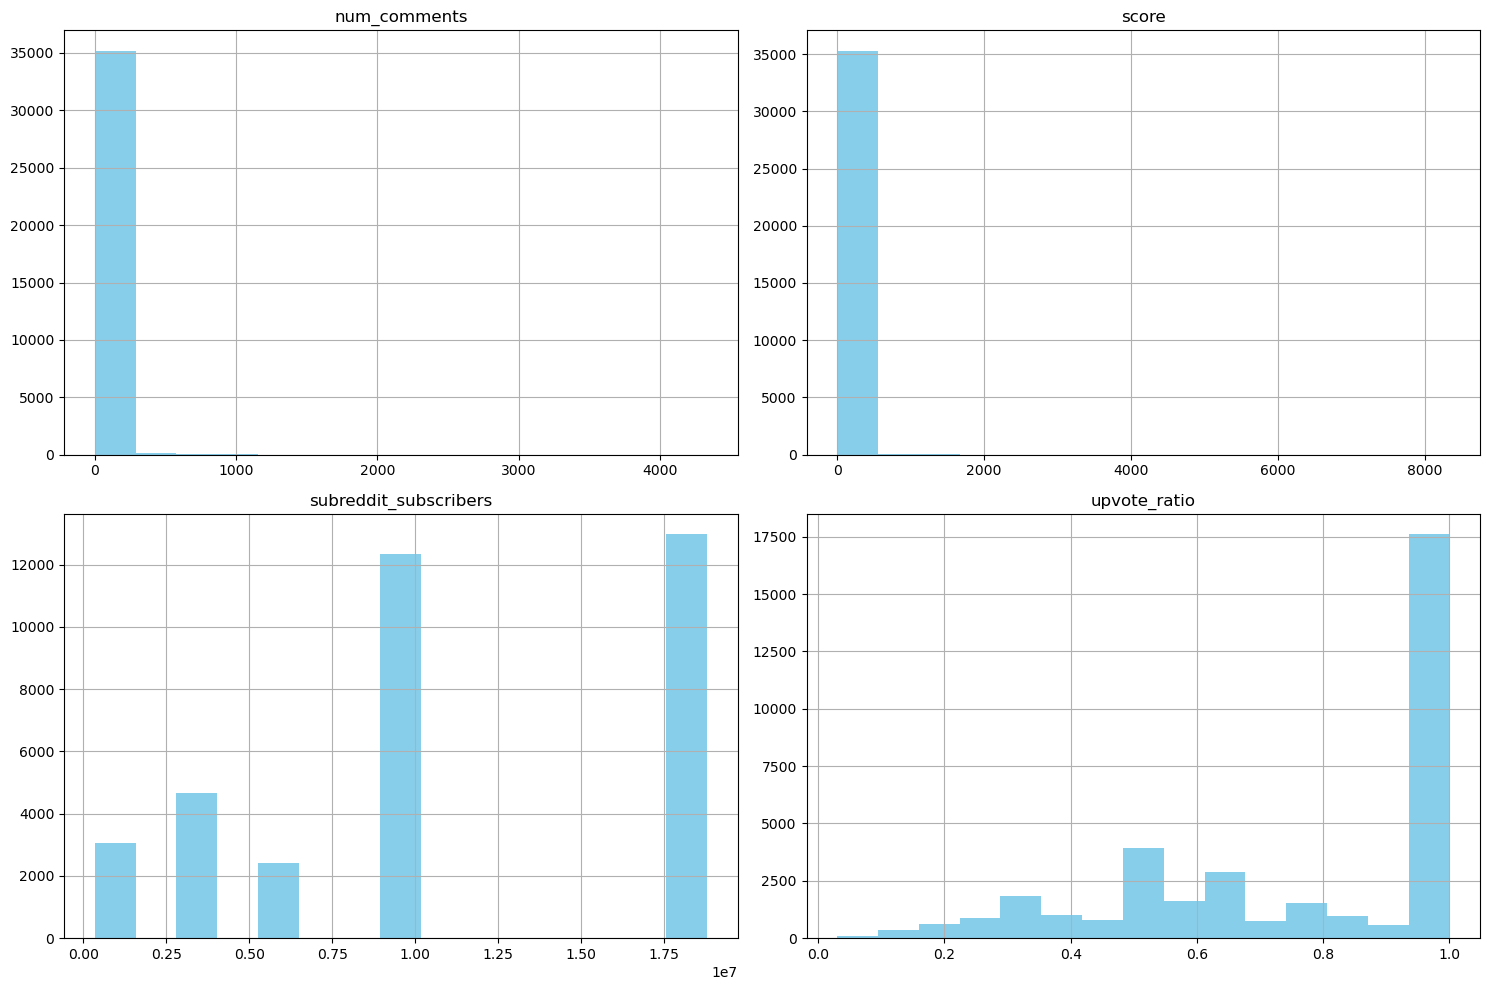

In [9]:
# Distribution Analysis - Histograms
df.hist(['num_comments', 'score', 'subreddit_subscribers', 'upvote_ratio'], bins=15, figsize=(15, 10), color='skyblue')
plt.tight_layout()
plt.show()

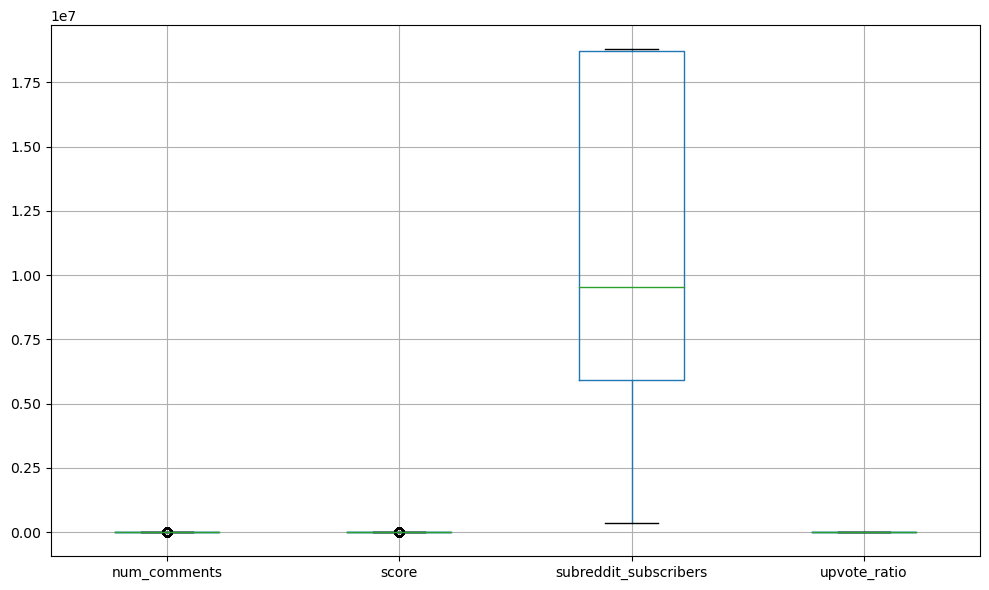

In [10]:
# Boxplots
df.boxplot(['num_comments', 'score', 'subreddit_subscribers', 'upvote_ratio'], figsize=(10, 6))
plt.tight_layout()
plt.show()

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/ac/66/937d1d73389c0b501c928c4d8513653063d2b40272dff70d0e283d8b9144/wordcloud-1.9.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 5.0 MB/s eta 0:00:00


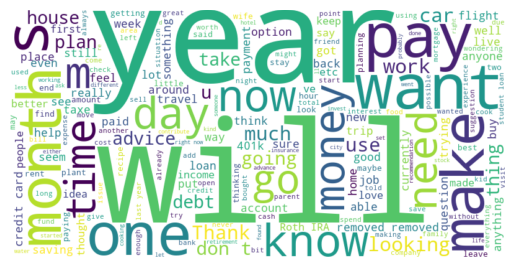

In [14]:
# Import the necessary library for WordCloud
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Make sure you have loaded your dataframe 'df' and it contains a column named 'selftext'

# Word Frequency Analysis - WordCloud for 'selftext'
text = ' '.join(df['selftext'].dropna())  # Assuming 'selftext' is the correct column name
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

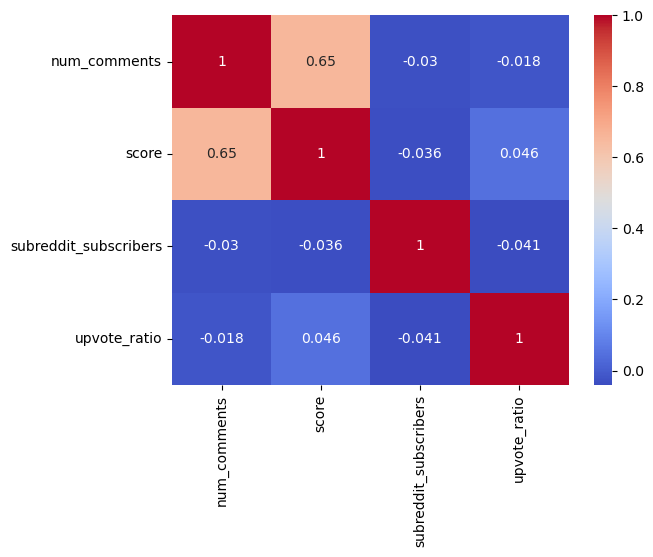

In [15]:
# 5. Correlation Analysis - Heatmap
correlation_matrix = df[['num_comments', 'score', 'subreddit_subscribers', 'upvote_ratio']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [17]:
# 7. Missing Values Analysis
missing_values = df.isnull().sum()
print(missing_values)

_meta                        0
all_awardings                0
allow_live_comments          0
approved_at_utc          35444
approved_by              35444
                         ...  
preview                  29303
crosspost_parent         34975
crosspost_parent_list    34975
author_cakeday           35319
poll_data                35443
Length: 118, dtype: int64


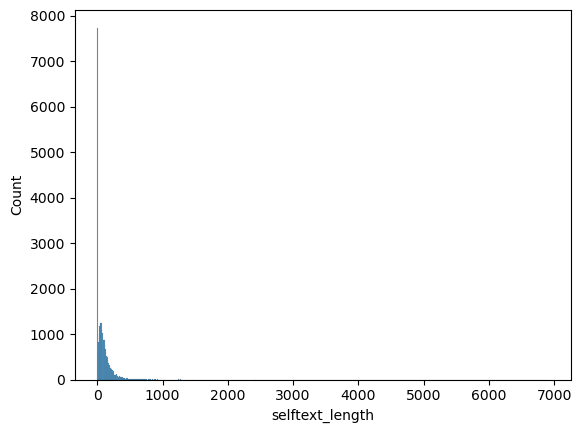

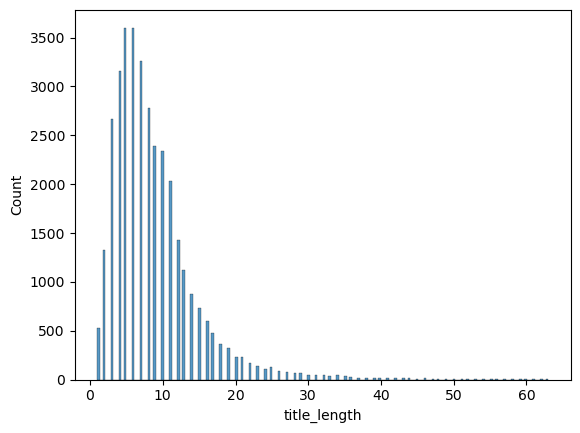

In [18]:
# 9. Text Length Analysis
df['selftext_length'] = df['selftext'].dropna().apply(lambda x: len(x.split()))
df['title_length'] = df['title'].apply(lambda x: len(x.split()))
sns.histplot(df['selftext_length'])
plt.show()
sns.histplot(df['title_length'])
plt.show()

In [19]:
# 10. Categorical Data Analysis - Comparing averages by category
average_by_over_18 = df.groupby('over_18')[['num_comments', 'score']].mean()
print(average_by_over_18)

         num_comments      score
over_18                         
False       12.238430  11.501684
True         1.529915   1.401709


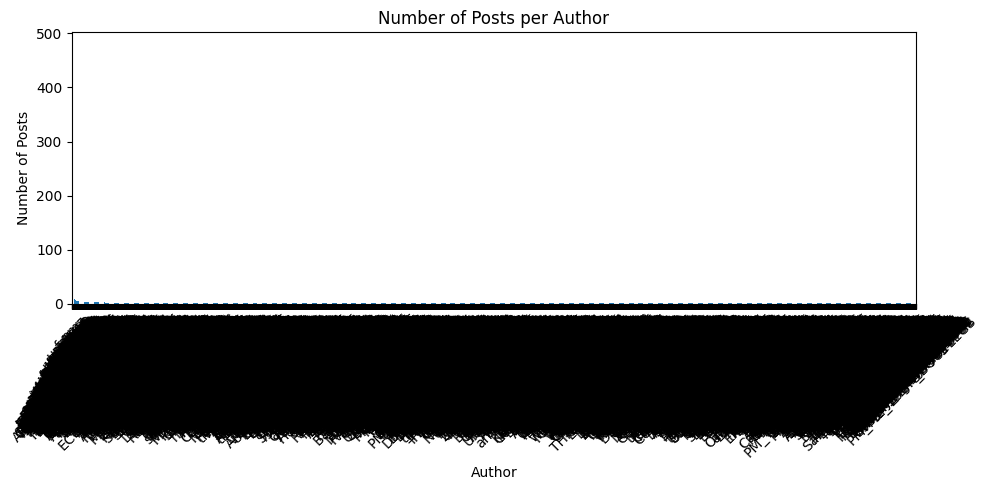

In [18]:
author_counts = df['author'].value_counts()
plt.figure(figsize=(10, 5))
author_counts.plot(kind='bar')
plt.title('Number of Posts per Author')
plt.xlabel('Author')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('author_posts.png', dpi=300)
plt.show()

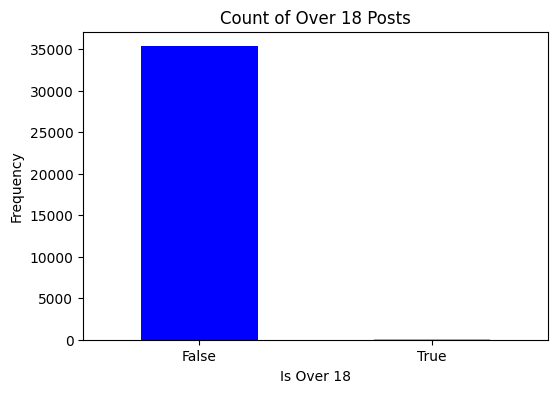

In [19]:
# Count plot of over_18
over_18_counts = df['over_18'].value_counts()

plt.figure(figsize=(6, 4))
over_18_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Count of Over 18 Posts')
plt.xlabel('Is Over 18')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

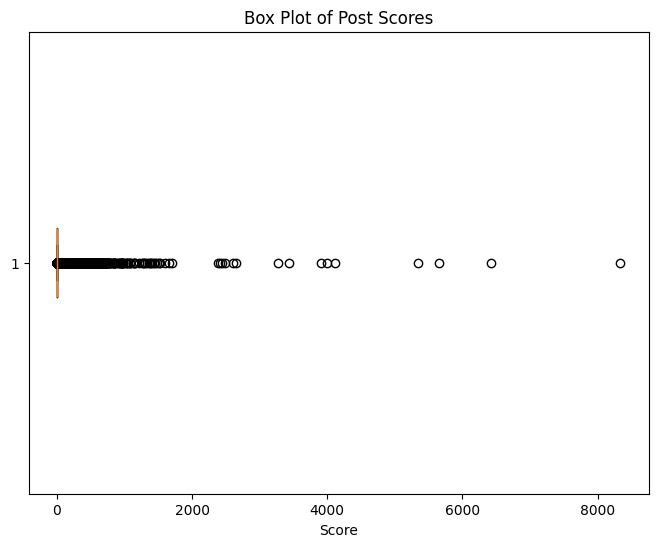

In [20]:
# Box plot of score
plt.figure(figsize=(8, 6))
plt.boxplot(df['score'], vert=False)
plt.title('Box Plot of Post Scores')
plt.xlabel('Score')
plt.show()

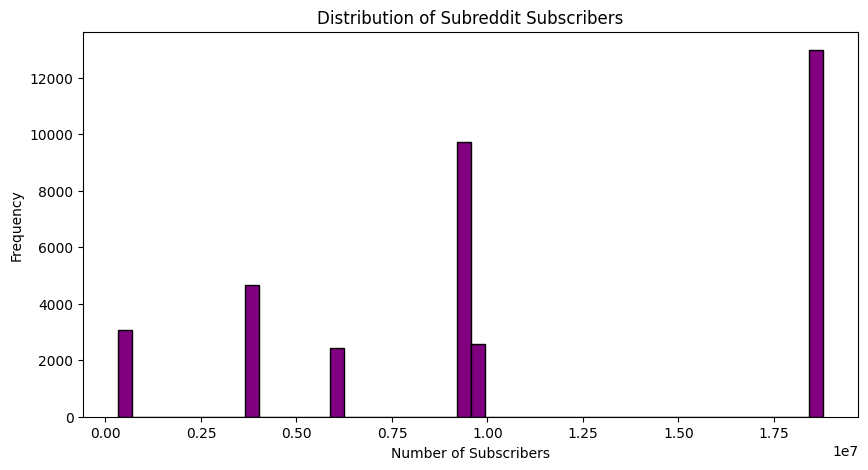

In [21]:
# Histogram of subreddit_subscribers
plt.figure(figsize=(10, 5))
plt.hist(df['subreddit_subscribers'], bins=50, color='purple', edgecolor='black')
plt.title('Distribution of Subreddit Subscribers')
plt.xlabel('Number of Subscribers')
plt.ylabel('Frequency')
plt.show()

/var/folders/k5/t469pkrn04384r93r5bs94780000gn/T/ipykernel_70008/1607504440.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_posts = df.resample('M', on='created_utc').size()
/Users/aafrinshaheen/anaconda3/envs/pyspark_env/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


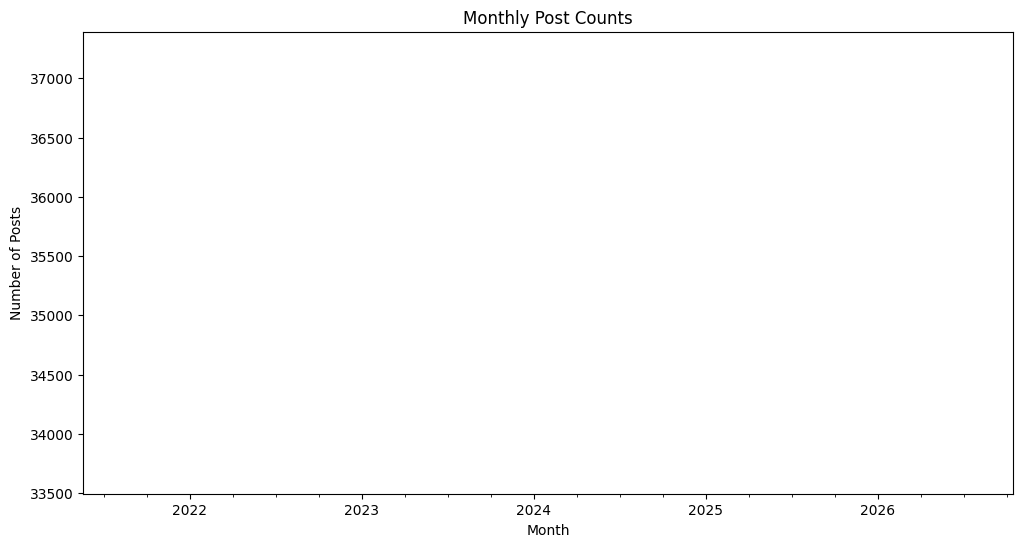

In [23]:
# Assuming 'created_utc' is a timestamp column in your dataset
# Convert to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

# Resampling to get monthly post counts
monthly_posts = df.resample('M', on='created_utc').size()

plt.figure(figsize=(12, 6))
monthly_posts.plot()
plt.title('Monthly Post Counts')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.show()

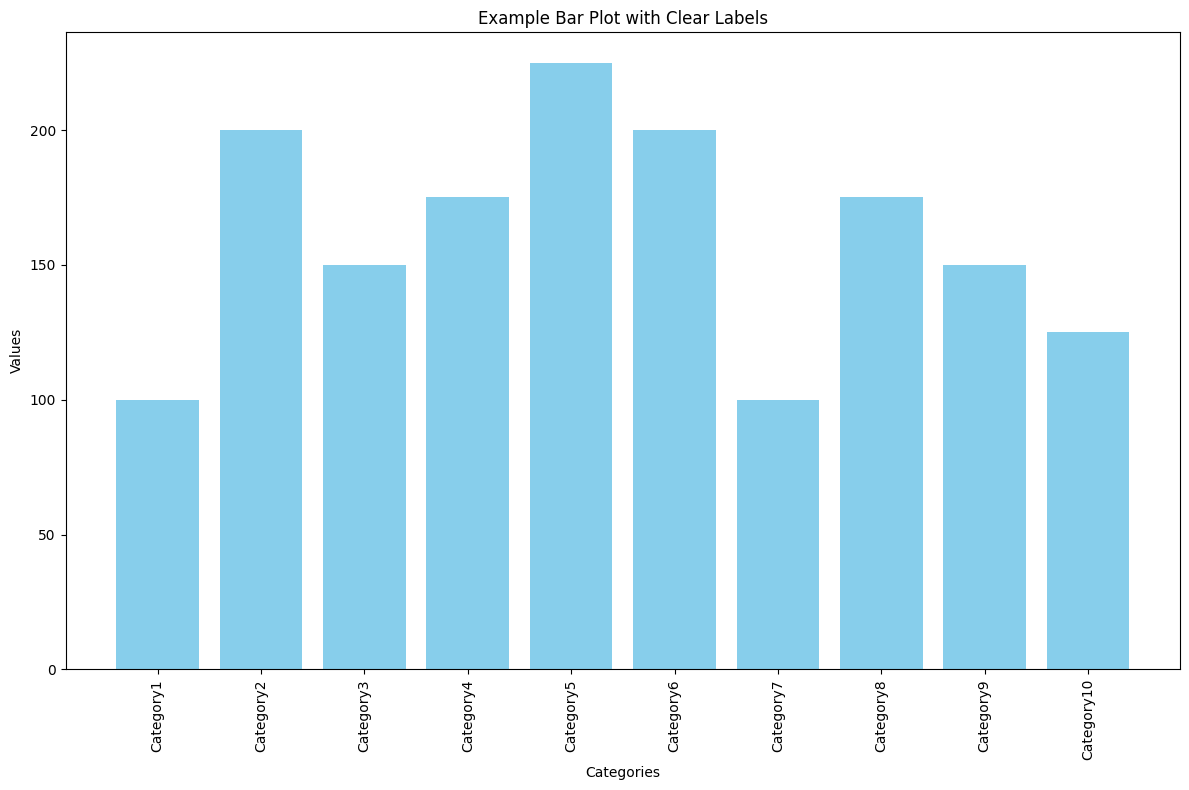

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data
categories = ['Category1', 'Category2', 'Category3', 'Category4', 'Category5',
              'Category6', 'Category7', 'Category8', 'Category9', 'Category10']
values = [100, 200, 150, 175, 225, 200, 100, 175, 150, 125]

# Creating the bar plot
plt.figure(figsize=(12, 8))  # Increase the figure size
plt.bar(categories, values, color='skyblue')
plt.title('Example Bar Plot with Clear Labels')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.xticks(rotation=90)  # Rotate labels to prevent overlap
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

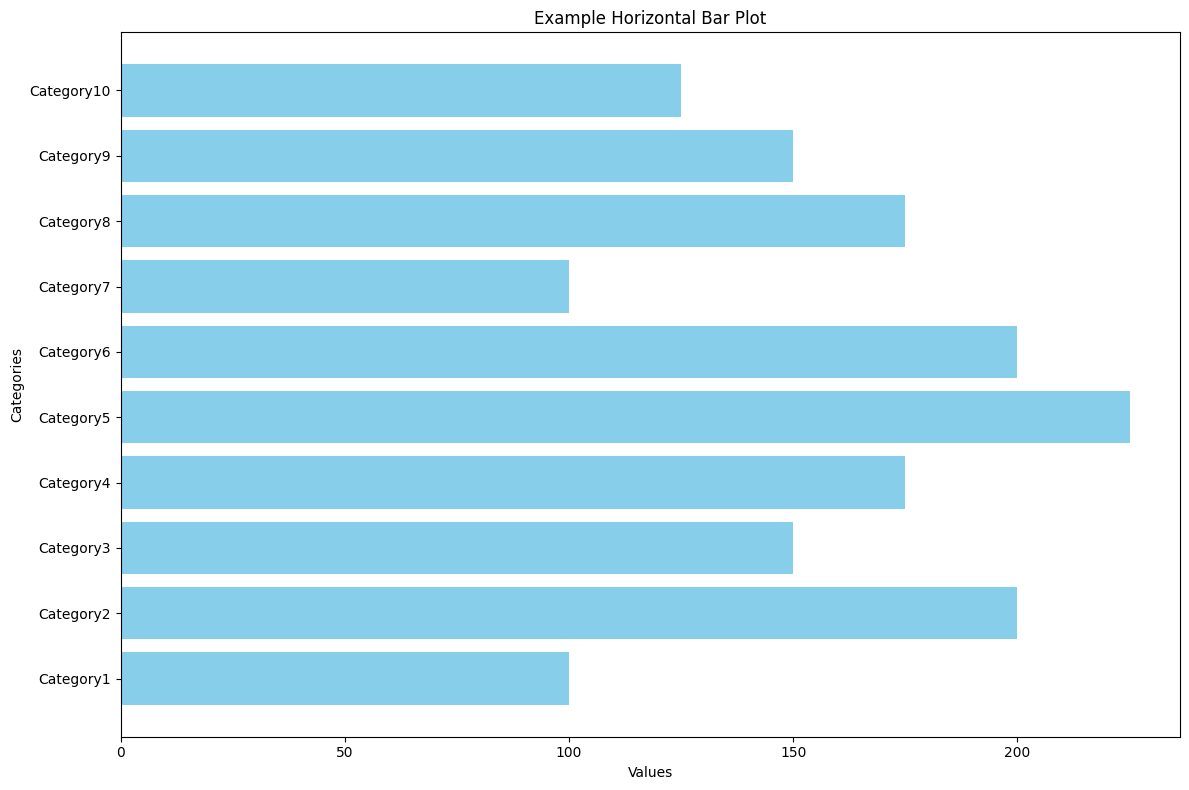

In [31]:
plt.figure(figsize=(12, 8))
plt.barh(categories, values, color='skyblue')  # Use horizontal bars
plt.title('Example Horizontal Bar Plot')
plt.xlabel('Values')
plt.ylabel('Categories')
plt.tight_layout()
plt.show()

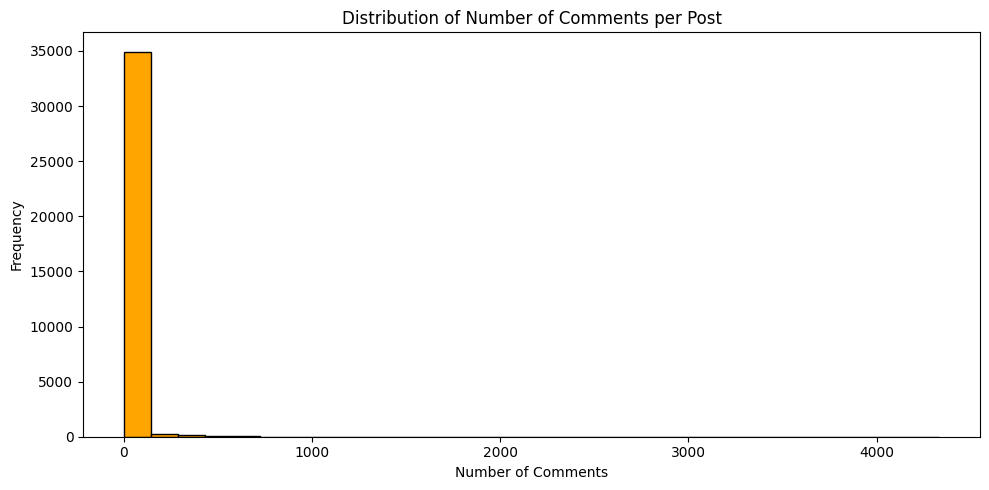

In [27]:
plt.figure(figsize=(10, 5))
plt.hist(df['num_comments'], bins=30, color='orange', edgecolor='black')
plt.title('Distribution of Number of Comments per Post')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('comments_distribution.png', dpi=300)
plt.show()

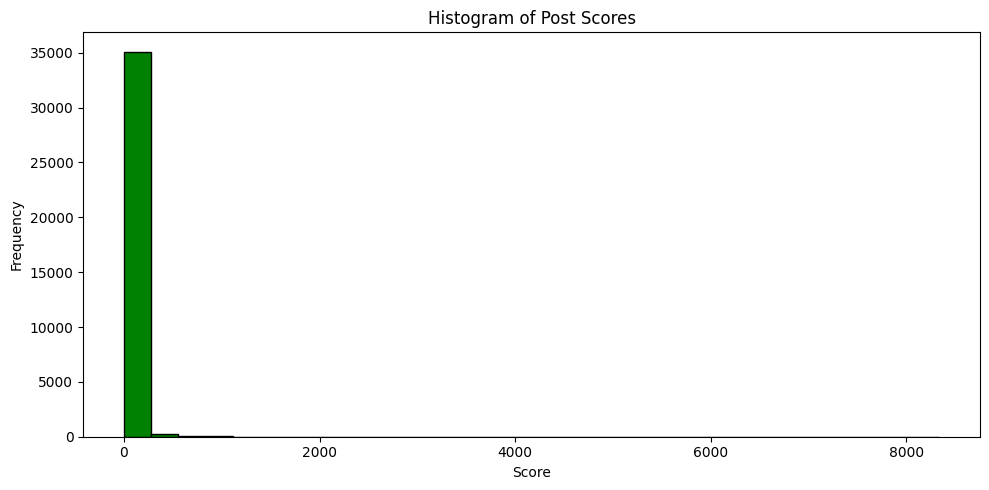

In [28]:
plt.figure(figsize=(10, 5))
plt.hist(df['score'], bins=30, color='green', edgecolor='black')
plt.title('Histogram of Post Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('score_histogram.png', dpi=300)
plt.show()

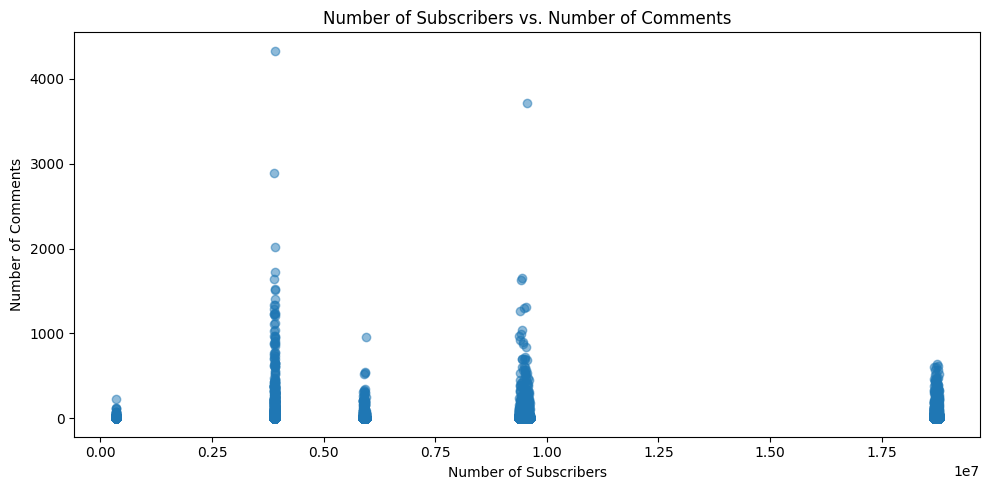

In [29]:
plt.figure(figsize=(10, 5))
plt.scatter(df['subreddit_subscribers'], df['num_comments'], alpha=0.5)
plt.title('Number of Subscribers vs. Number of Comments')
plt.xlabel('Number of Subscribers')
plt.ylabel('Number of Comments')
plt.tight_layout()
plt.show()